In [1]:
import ccxt
import pandas as pd
import os

# --- Configurable Parameters ---
TRADE_AMOUNT = 10  # Trade amount in USD
DEFAULT_FEE = 0.001  # Default maker/taker fee (0.1% per trade)
RESULTS_FILE = "arbitrage_results.csv"

# --- Function to Fetch Liquidity ---
def get_liquidity(exchange_name, symbol):
    """Fetches the 24-hour trading volume (liquidity) for a given symbol on Binance or Bybit."""
    try:
        exchange = getattr(ccxt, exchange_name)()

        # Try fetching liquidity from fetch_ticker
        ticker = exchange.fetch_ticker(symbol)
        quote_volume = ticker.get("quoteVolume", None) or ticker.get("baseVolume", None)

        # If ticker volume is missing, check order book liquidity
        if not quote_volume:
            order_book = exchange.fetch_order_book(symbol)
            top_bid = order_book["bids"][0][1] if order_book["bids"] else 0
            top_ask = order_book["asks"][0][1] if order_book["asks"] else 0
            quote_volume = top_bid + top_ask  # Sum of top bid & ask volumes

        return quote_volume if quote_volume else "N/A"

    except Exception as e:
        print(f"⚠️ Error fetching liquidity for {symbol} on {exchange_name}: {e}")
        return "N/A"

# --- Function to Get Exchange Info ---
def get_exchange_info(exchange_name):
    """Fetches trading information for a given exchange, including fees and liquidity data."""
    try:
        exchange = getattr(ccxt, exchange_name)()

        # Always use default fee values (0.1% per trade)
        trading_fees = {"maker_fee": DEFAULT_FEE, "taker_fee": DEFAULT_FEE}

        # Fetch market symbols (USDT pairs only)
        markets = exchange.load_markets()
        usdt_pairs = [s for s in markets.keys() if "USDT" in s]

        return {
            "Exchange": exchange_name,
            "Trading Fees": trading_fees,
            "Supported Symbols": usdt_pairs  # List of tradable USDT pairs
        }
    
    except Exception as e:
        print(f"⚠️ Could not retrieve data for {exchange_name}: {e}")
        return {"Error": str(e)}

# --- Function to Compare Fees, Spreads, and Liquidity ---
def compare_fees_spreads_liquidity(exchange1_name, exchange2_name):
    """Compares trading fees, spreads, and liquidity for common USDT pairs between two exchanges."""
    if exchange1_name == exchange2_name:
        raise ValueError("❌ Both exchanges are the same. Please enter two different exchanges.")

    if not hasattr(ccxt, exchange1_name) or not hasattr(ccxt, exchange2_name):
        raise ValueError("❌ One or both exchanges are not listed in CCXT. Check your inputs.")

    # Fetch exchange information
    exchange1_info = get_exchange_info(exchange1_name)
    exchange2_info = get_exchange_info(exchange2_name)

    # Find common trading symbols
    symbols1 = set(exchange1_info.get("Supported Symbols", []))
    symbols2 = set(exchange2_info.get("Supported Symbols", []))
    common_symbols = list(symbols1 & symbols2)

    print(f"✅ Found {len(common_symbols)} common USDT trading pairs between {exchange1_name} and {exchange2_name}")

    if not common_symbols:
        raise ValueError(f"❌ No common **USDT** trading pairs found between {exchange1_name} and {exchange2_name}.")

    # Connect to exchanges
    exchange1 = getattr(ccxt, exchange1_name)()
    exchange2 = getattr(ccxt, exchange2_name)()

    results = []

    for symbol in common_symbols:
        print(f"🔄 Fetching data for {symbol}...")

        try:
            # Fetch latest prices
            price1 = exchange1.fetch_ticker(symbol).get("last", None)
            price2 = exchange2.fetch_ticker(symbol).get("last", None)

            # Ensure prices are valid
            if price1 is None or price2 is None:
                print(f"⚠️ Missing price data for {symbol}, skipping...")
                continue

            # Calculate spread percentage
            spread = abs(price1 - price2) / ((price1 + price2) / 2) * 100

            # Get trading fees (Default to 0.1% per trade)
            fee1 = exchange1_info["Trading Fees"]
            fee2 = exchange2_info["Trading Fees"]

            # Fetch liquidity dynamically
            liquidity1 = get_liquidity(exchange1_name, symbol)
            liquidity2 = get_liquidity(exchange2_name, symbol)

            # Calculate potential profit
            potential_profit = calculate_potential_profit(price1, price2, fee1["taker_fee"], fee2["taker_fee"], TRADE_AMOUNT)

            results.append({
                "Symbol": symbol,
                "Exchange 1": exchange1_name,
                "Exchange 2": exchange2_name,
                "Price 1": price1,
                "Price 2": price2,
                "Average Price": (price1 + price2) / 2,
                "Spread (%)": spread,
                "Exchange 1 Maker Fee": fee1["maker_fee"],
                "Exchange 1 Taker Fee": fee1["taker_fee"],
                "Exchange 2 Maker Fee": fee2["maker_fee"],
                "Exchange 2 Taker Fee": fee2["taker_fee"],
                "Exchange 1 Liquidity (24h Vol)": liquidity1,
                "Exchange 2 Liquidity (24h Vol)": liquidity2,
                "Potential Profit ($)": potential_profit
            })

        except Exception as e:
            print(f"⚠️ Error fetching data for {symbol}: {e}")
            continue  # Skip symbols that cause errors

    # Convert to a DataFrame for better visualization
    df = pd.DataFrame(results)

    # Replace NaN values with "N/A"
    df.fillna("N/A", inplace=True)

    if df.empty:
        raise ValueError("❌ No valid trading pairs with price and liquidity data found.")

    return df

# --- Function to Calculate Potential Profit ---
def calculate_potential_profit(price1, price2, fee1, fee2, trade_amount):
    """Calculates the potential profit for a given trade amount."""
    
    # Determine Buy & Sell Prices
    buy_price = min(price1, price2)
    sell_price = max(price1, price2)

    # Determine Fees
    buy_fee = fee1 if buy_price == price1 else fee2
    sell_fee = fee2 if sell_price == price2 else fee1

    # Calculate Crypto Amount Bought
    crypto_amount = trade_amount / buy_price

    # Calculate Trading Fees
    buy_fee_cost = buy_price * crypto_amount * buy_fee
    sell_fee_cost = sell_price * crypto_amount * sell_fee
    total_fees = buy_fee_cost + sell_fee_cost

    # Calculate Raw Profit
    raw_profit = (sell_price - buy_price) * crypto_amount

    # Calculate Final Profit (After Fees)
    final_profit = raw_profit - total_fees
    return round(final_profit, 4)  # Round to 4 decimal places for clarity

# --- Run & Save Results ---
if not os.path.exists(RESULTS_FILE):
    try:
        exchange1 = "binance"
        exchange2 = "bybit"
        result_df = compare_fees_spreads_liquidity(exchange1, exchange2)

        # Save results
        result_df.to_csv(RESULTS_FILE, index=False)
        print(f"📁 Results saved to {RESULTS_FILE}")

        # Display the results
        display(result_df)

    except ValueError as e:
        print(e)
else:
    result_df = pd.read_csv(RESULTS_FILE)
    print("✅ Loaded saved results.")


✅ Loaded saved results.


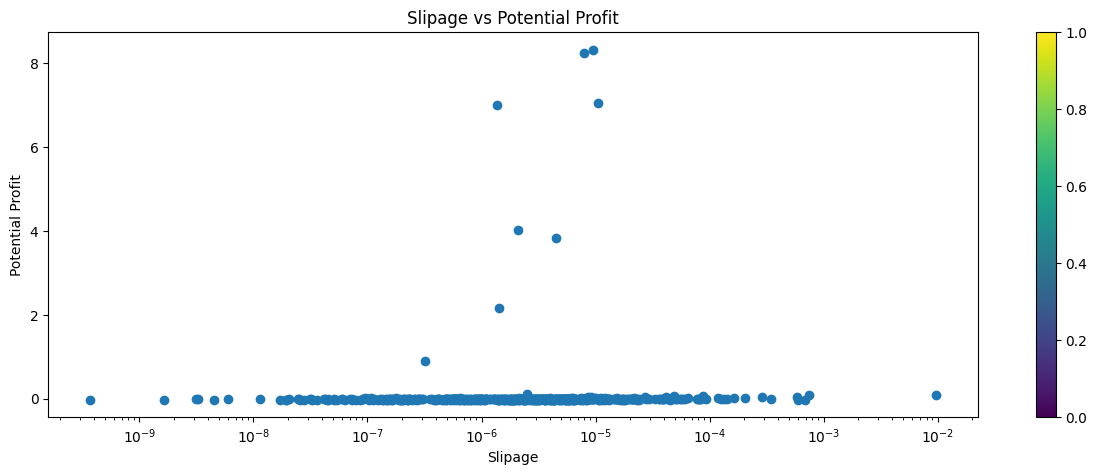

,Symbol,Exchange 1,Exchange 2,Price 1,Price 2,Average Price,Spread (%),Exchange 1 Maker Fee,Exchange 1 Taker Fee,Exchange 2 Maker Fee,Exchange 2 Taker Fee,Exchange 1 Liquidity (24h Vol),Exchange 2 Liquidity (24h Vol),Potential Profit ($),Exchange 1 slipage,Exchange 2 slipage,Slipage
263,IDEX/USDT:USDT,binance,bybit,0.056100,0.030570,0.043335,58.913119,0.001,0.001,0.001,0.001,2.205403e+06,6.853785e+05,8.3230,4.534319e-06,1.459048e-05,9.562398e-06
271,SLP/USDT:USDT,binance,bybit,0.003515,0.001924,0.002719,58.503401,0.001,0.001,0.001,0.001,4.000750e+06,7.558640e+05,8.2410,2.499531e-06,1.322989e-05,7.864712e-06
270,ORBS/USDT:USDT,binance,bybit,0.035157,0.020600,0.027879,52.215865,0.001,0.001,0.001,0.001,4.744390e+06,5.326405e+05,7.0394,2.107753e-06,1.877439e-05,1.044107e-05
109,XEM/USDT:USDT,binance,bybit,0.033800,0.019860,0.026830,51.956765,0.001,0.001,0.001,0.001,9.727490e+06,5.921262e+06,6.9921,1.028014e-06,1.688829e-06,1.358422e-06
21,STPT/USDT:USDT,binance,bybit,0.053060,0.074570,0.063815,33.706809,0.001,0.001,0.001,0.001,3.140301e+06,9.648328e+06,4.0298,3.184408e-06,1.036449e-06,2.110429e-06
537,SNT/USDT:USDT,binance,bybit,0.036660,0.026440,0.031550,32.393027,0.001,0.001,0.001,0.001,3.406851e+07,1.144675e+06,3.8415,2.935262e-07,8.736100e-06,4.514813e-06
388,OMG/USDT:USDT,binance,bybit,0.291000,0.238700,0.264850,19.747027,0.001,0.001,0.001,0.001,1.092036e+07,5.197801e+06,2.1688,9.157208e-07,1.923891e-06,1.419806e-06
112,WAVES/USDT:USDT,binance,bybit,1.335500,1.459500,1.397500,8.872987,0.001,0.001,0.001,0.001,7.279406e+07,1.999198e+07,0.9076,1.373738e-07,5.002006e-07,3.187872e-07
339,CVX/USDT:USDT,binance,bybit,2.374000,2.344000,2.359000,1.271725,0.001,0.001,0.001,0.001,3.552591e+06,4.642957e+06,0.1079,2.814847e-06,2.153800e-06,2.484323e-06
302,JST/USDT,binance,bybit,0.032280,0.032640,0.032460,1.109057,0.001,0.001,0.001,0.001,8.530501e+05,5.174724e+02,0.0914,1.172264e-05,1.932470e-02,9.668212e-03


In [7]:
from matplotlib import pyplot as plt

result_df['Exchange 1 slipage'] = TRADE_AMOUNT / result_df['Exchange 1 Liquidity (24h Vol)']
result_df['Exchange 2 slipage'] = TRADE_AMOUNT / result_df['Exchange 2 Liquidity (24h Vol)']

result_df['Slipage'] = result_df[['Exchange 1 slipage', 'Exchange 2 slipage']].mean(axis=1)
result_df = result_df[result_df['Potential Profit ($)']<10]
plt.figure(figsize=(15, 5))
plt.scatter(result_df['Slipage'], result_df['Potential Profit ($)'])
plt.colorbar()
plt.xlabel('Slipage')
plt.xscale('log')
plt.ylabel('Potential Profit')
plt.title('Slipage vs Potential Profit')
plt.show()

# Display the 10 most profitable results
top_10_profitable = result_df.nlargest(10, 'Potential Profit ($)')
display(top_10_profitable)
top_10_profitable.to_csv('top_10_profitable.csv', index=False)